Redes Pi-Sigma 
===

* 41:42 min | Última modificación: Mayo 31, 2021 | [YouTube]

In [1]:
import warnings

warnings.filterwarnings("ignore")

## Definición

Esta es una red neuronal de alto orden, con una sola capa oculta y las siguiente características:

* La activación de las neuronas de la capa oculta es realizada con la función identidad $g(x) = x$.

* La capa de salida no tiene una neurona bias.

* La función de agregación de la neurona de la capa de salida es una multiplicatoria.

* La neurona de salida tiene una función de activación sigmoidea

$$
y = \sigma 
\left(
\prod_h (w_h^* + \sum_i w_{i,h} x_i)
\right)
$$

donde:

* $w_h^*$ representan los pesos de las neuronas bias en la capa oculta.

* $\sigma()$ es la función de activación.

* $w_{i,h}$ es el peso de la conexión que va de la entrada $i$ a la neurona $h$ de la capa oculta.

![assets/po-sigma-network.png](assets/pi-sigma-network.png)

## Caso de aplicación

In [2]:
import pandas as pd

df = pd.read_csv(
    "https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/concrete.csv",
    sep=",",  
    thousands=None,
    decimal=".",
)  

df.head()

cement   slag  ash  water  superplastic  coarseagg  fineagg  age  strength
0   540.0    0.0  0.0  162.0           2.5     1040.0    676.0   28     79.99
1   540.0    0.0  0.0  162.0           2.5     1055.0    676.0   28     61.89
2   332.5  142.5  0.0  228.0           0.0      932.0    594.0  270     40.27
3   332.5  142.5  0.0  228.0           0.0      932.0    594.0  365     41.05
4   198.6  132.4  0.0  192.0           0.0      978.4    825.5  360     44.30

## Preparación de los datos en scikit-learn

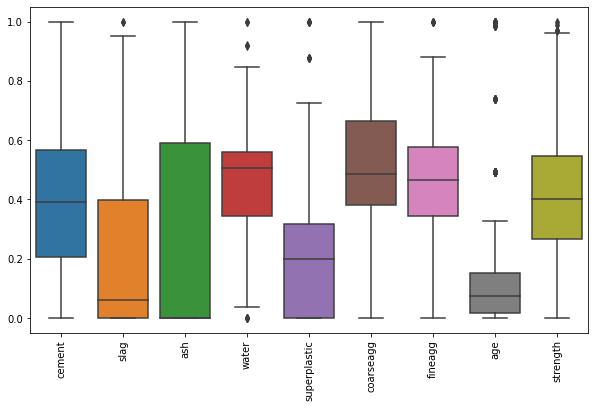

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

#
#  Se escalan todas las variables al rango [0, 1]
#  para evitar problemas asociados a la escala
#
scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_norm)
plt.xticks(rotation=90);

In [4]:
X_train = df_norm.drop(columns="strength")
y_train = df_norm.strength

## Preparación de los datos en TensorFlow

In [5]:
import tensorflow as tf

dataset_train = tf.data.Dataset.from_tensor_slices(
    (X_train.values, y_train.values)
).batch(1)

for feat, targ in dataset_train.take(5):
    print ('Features: {}, Target: {}'.format(feat, targ))

Features: [[1.         0.         0.         0.32108626 0.07763975 0.69476744
  0.20572002 0.07417582]], Target: [0.96748474]
Features: [[1.         0.         0.         0.32108626 0.07763975 0.73837209
  0.20572002 0.07417582]], Target: [0.74199576]
Features: [[0.52625571 0.39649416 0.         0.84824281 0.         0.38081395
  0.         0.73901099]], Target: [0.47265479]
Features: [[0.52625571 0.39649416 0.         0.84824281 0.         0.38081395
  0.         1.        ]], Target: [0.48237199]
Features: [[0.22054795 0.36839176 0.         0.56070288 0.         0.51569767
  0.58078274 0.98626374]], Target: [0.52286035]


## Modelo

In [6]:
from tensorflow.keras import backend as K

class PiSigma(tf.keras.Model):
    def __init__(self, H, name="pi_sigma_network", **kwargs):
        super(PiSigma, self).__init__(name=name, **kwargs)
        self.inputs = tf.keras.Input(shape=(None, 8))
        self.hidden_layer = tf.keras.layers.Dense(units=H)

    def call(self, inputs):
        out = self.hidden_layer(inputs)
        out = K.prod(out,  axis=1)
        out = tf.keras.activations.sigmoid(out)
        return out

In [7]:
def compile_and_evaluate(model):
    model.compile(optimizer="adam", loss="mean_squared_error")
    model.fit(dataset_train, epochs=20, verbose=0)
    return model.evaluate(dataset_train, verbose=0)

## Modelos

In [8]:
#
# Diccionario para guardar los resultados para cada modelo
#
results = {}

In [9]:
for h in range(1, 6):
    results[h] = compile_and_evaluate(PiSigma(H=h))
    print("H={}, loss={}".format(h, results[h]))

H=1, loss=0.018922824412584305
H=2, loss=0.013441460207104683
H=3, loss=0.014006700366735458
H=4, loss=0.013145573437213898
H=5, loss=0.013124664314091206


## Resultados

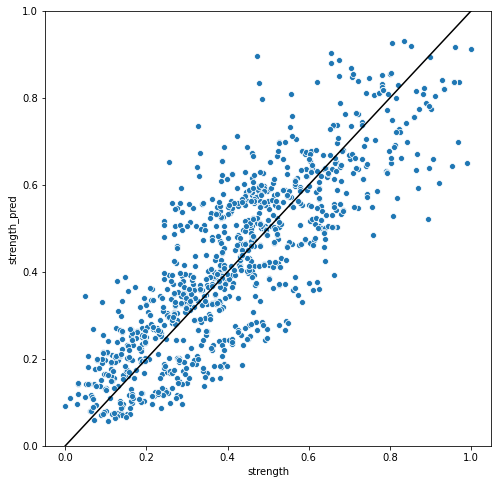

In [10]:
import numpy as np

H_OPT = np.argmin(np.array([results[k] for k in results.keys()])) + 1

model = PiSigma(H=H_OPT)
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(dataset_train, epochs=20, verbose=0)

df_norm["strength_pred"] = model.predict(X_train)


plt.figure(figsize=(8, 8))
sns.scatterplot(x="strength", y="strength_pred", data=df_norm)
plt.plot([0, 1], [0, 1], color="black")
plt.ylim(0, 1)
plt.show()